In [135]:
import warnings
warnings.filterwarnings("ignore")
import os
import math 
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime 
from pandas.plotting import register_matplotlib_converters 
import matplotlib.pyplot as plt 
plt.style.use("fivethirtyeight")
import matplotlib.dates as mdates 

from decimal import ROUND_HALF_UP, Decimal
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

from lightgbm import LGBMRegressor
from tqdm import tqdm

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping # EarlyStopping during model training

import seaborn as sns 
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

In [136]:
def adjust_price(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = df["CumulativeAdjustmentFactor"] * df["Close"]
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        df["Close"] = df["AdjustedClose"]
        df = df.drop(['AdjustedClose'], axis=1)
        df = df.drop(['CumulativeAdjustmentFactor'], axis=1)
        df = df.drop(['AdjustmentFactor'], axis=1)
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)

    price.set_index("Date", inplace=True)
    return price

In [137]:
df = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv")
df = adjust_price(df)
df_supp =  pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv")
df_supp = adjust_price(df_supp)
Sclist = df.SecuritiesCode.unique()

In [138]:
df = df.loc[df["SecuritiesCode"] == Sclist[1]]
df_supp = df_supp.loc[df_supp["SecuritiesCode"] == Sclist[1]]

In [139]:
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
df_supp = df_supp.fillna(method='ffill')
df_supp = df_supp.fillna(method='bfill')

In [140]:
df = df[["Open","High","Low","Close","Volume"]]
df_supp = df_supp[["Open","High","Low","Close","Volume"]]

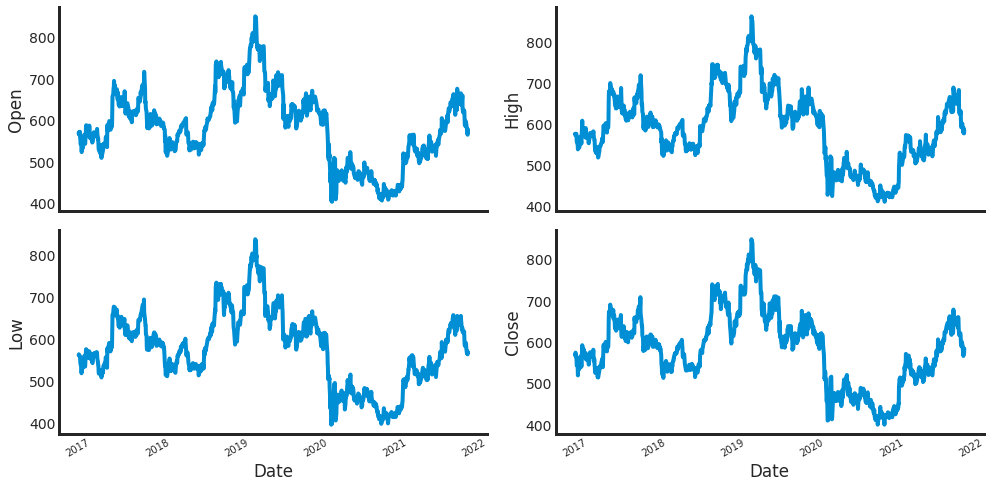

In [141]:
# Plot line charts
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [142]:
train_df = df.sort_values(by=['Date']).copy()

FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume']

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered_ext = data.copy()
data_filtered_ext['Prediction'] = data_filtered_ext["Close"].shift(-1)
data_filtered_ext['Prediction'] = data_filtered_ext['Prediction'].ffill()

In [143]:
# Get the number of rows in the data
nrows = data.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data)
np_data = np.reshape(np_data_unscaled, (nrows, -1))

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Prediction'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

In [144]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 90
index_Close = data.columns.get_loc('Close')

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(872, 90, 5) (872,)
(240, 90, 5) (240,)
0.4084821428571429
0.4084821428571429


In [145]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

450 90 5


In [146]:
# Training the model
epochs = 6
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )

Epoch 1/6
55/55 [==============================] - 47s 763ms/step - loss: 0.0179 - val_loss: 0.0013
Epoch 2/6
55/55 [==============================] - 41s 738ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 3/6
55/55 [==============================] - 39s 714ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 4/6
55/55 [==============================] - 40s 736ms/step - loss: 0.0019 - val_loss: 9.7578e-04
Epoch 5/6
55/55 [==============================] - 38s 686ms/step - loss: 0.0016 - val_loss: 9.2495e-04
Epoch 6/6
55/55 [==============================] - 38s 684ms/step - loss: 0.0018 - val_loss: 9.5375e-04


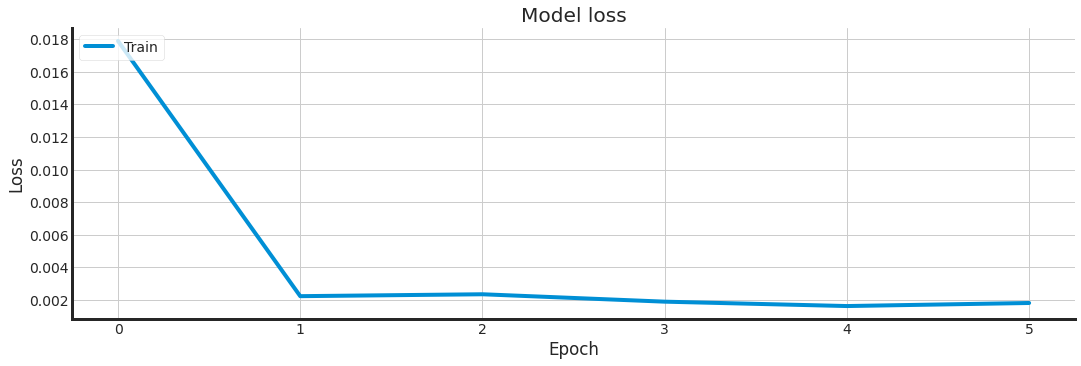

In [147]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [148]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 10.02
Mean Absolute Percentage Error (MAPE): 1.82 %
Median Absolute Percentage Error (MDAPE): 1.31 %


<AxesSubplot:title={'center':'predict vs valid'}, xlabel='Date', ylabel='1301'>

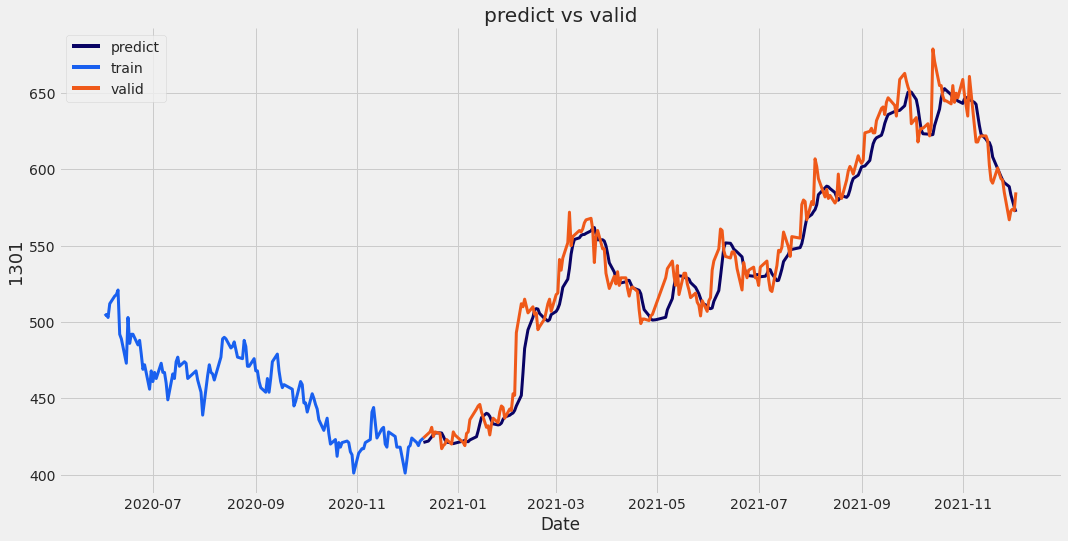

In [149]:
# The date from which on the date is displayed
display_start_date = "2020-6-01" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext[col][:train_data_len + 1]).rename(columns={col: 'train'})
valid = pd.DataFrame(data_filtered_ext[col][train_data_len:]).rename(columns={col: 'valid'})
valid.insert(1, "predict", y_pred, True)
valid.insert(1, "residuals", valid["predict"] - valid["valid"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
plt.style.use("fivethirtyeight")
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("predict vs valid")
plt.ylabel(1301, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['predict', 'train', 'valid']], linewidth=3.0, dashes=False, ax=ax1)

